# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [344]:
from sklearn import datasets
from sklearn import metrics

In [433]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        
        self.loss_values_array = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        w = weights
        return 1.0 / (1.0 + np.exp(-np.dot(X, w)))
        
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        # low accuracy axample
        # temp = []
        """loss_y = []
        loss_x = []
        i = 1
        for J in range(x.shape[0]):
            q = np.log(1 + np.exp(-weights[1:] @ x[J] * y[J]))
            temp.append(q)
            qq = np.sum(temp, axis=0) / x.shape[0] + ((weights.T @ weights) / (2 * self.C))
            loss_y.append(qq)
            loss_x.append(i)
            i = i + 1
            return(loss_x, loss_y)
        return qq"""
        slog_1 =  (np.log(1 + np.exp(-np.dot(x, weights) * y))).mean()
        slog_2 = 1.0 / (2.0 * self.C) * np.amin((np.linalg.norm(weights)) ** 2)
        loss = slog_1 + slog_2
        self.loss_values_array.append(loss)
        return loss
        
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        # low accurasy axample
        """for i in range(self.max_iter):
            self.loss_values_array.append(self.get_loss(X, self.weights_, y))
            loss_terms_array = []
            for J in range(y.shape[0]):
                loss_terms_list = y[J] * X_ext[J, :] * (1 - 1/(1 + np.exp(-X_ext[J, :] @ self.weights_ * y[J])))
                loss_terms_array.append(loss_terms_list)
            delta = (- np.sum(np.array(loss_terms_array), axis=0) / X_ext.shape[0]) + (self.weights_ / self.C)
            self.weights_ -= self.eta * delta
            W_from_t = self.weights_ + (self.eta * delta)
            if np.linalg.norm(-self.weights_ - W_from_t) < self.tol:
                    break"""
        # high accuracy example
        delta = 0
        for i in range(self.max_iter):
            delta = X_ext.T @ (y * (1. - 1. / (1 + np.exp(np.dot(-X_ext,
                               self.weights_) * y)))) / len(y) - (1 / self.C) * self.weights_
            self.weights_ -= self.eta * delta * (-1.)
            self.get_loss(X_ext, self.weights_, y)
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        if hasattr(self, 'weights_'):
            return np.where(self.predict_proba(X) >= .5, 1, -1)
        else:
            raise NotFittedError('Model is not fitted yet')

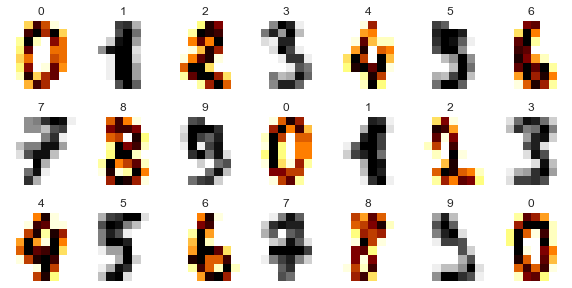

In [434]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [435]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [436]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [437]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [438]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [439]:
lr_clf.fit(X_train, y_train)

In [440]:
print(f'In train set are: {X_train.shape} information')

In train set are: (1437, 64) information


In [441]:
len(lr_clf.weights_)

65

In [442]:
print(lr_clf.weights_)

[ 3.13152401e-06  0.00000000e+00  4.17536534e-05  5.47668754e-04
  2.21294363e-04  4.87473904e-04  1.35768963e-03  5.97773138e-04
  5.63674322e-05 -6.95894224e-07  1.69102296e-04  2.51913709e-04
 -4.37021573e-04  3.61864997e-04  1.00487126e-03  4.22755741e-04
  2.57480863e-05  3.47947112e-07 -1.14822547e-05 -7.24425887e-04
 -2.62004175e-04  8.75434934e-04  4.15448852e-04 -8.42032011e-05
 -5.21920668e-06  0.00000000e+00 -2.21642310e-04 -5.71329158e-04
  9.85734168e-04  1.35073069e-03  5.02087683e-04 -1.70494085e-04
 -1.04384134e-06  0.00000000e+00 -6.78148921e-04 -1.05149617e-03
 -4.45372303e-05  3.71607516e-04  4.21016006e-04 -8.17675713e-05
  0.00000000e+00 -5.21920668e-06 -5.34098817e-04 -2.03931802e-03
 -8.43075852e-04  1.04036186e-04 -1.23869172e-04 -1.78844816e-04
 -1.32219903e-05 -4.52331246e-06 -9.42936674e-05 -1.11273486e-03
 -5.09046625e-04 -2.18510786e-04 -5.60542797e-04 -3.95615866e-04
 -1.77453027e-05 -3.47947112e-07  2.67919276e-05  6.39178845e-04
  1.80932498e-04 -7.36604

In [443]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [444]:
model = CustomLogisticRegression()

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


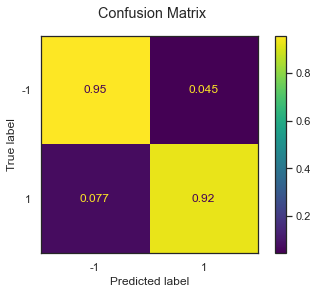

In [445]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)


In [446]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [447]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0.5, 1.0, 'Зависимость функции потерь от времени')

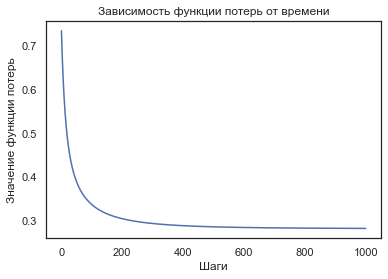

In [490]:
# Initialize plot
plot = plt.figure()

# Plot
ax = plot.add_subplot(1, 1, 1)
ax.plot(model.loss_values_array)

# Data
ax.set_xlabel('Шаги')
ax.set_ylabel('Значение функции потерь')
ax.set_title('Зависимость функции потерь от времени')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [491]:
## your code
model_1 = CustomLogisticRegression(eta=0.005)
model_1.fit(X_train, y_train)

In [492]:
model_2 = CustomLogisticRegression(eta=0.01)
model_2.fit(X_train, y_train)

In [493]:
model_3 = CustomLogisticRegression(eta=0.015)
model_3.fit(X_train, y_train)

Text(0.5, 1.0, 'Lost function from time')

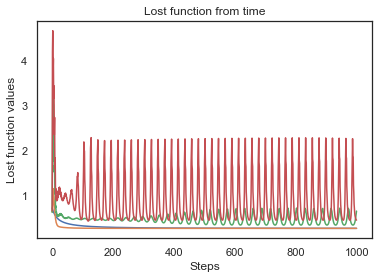

In [494]:
# Initialize plot
plot_2 = plt.figure()

# Plot
ax = plot_2.add_subplot(1, 1, 1)
ax.plot(model.loss_values_array)

# add another models
ax.plot(model_1.loss_values_array)
ax.plot(model_2.loss_values_array)
ax.plot(model_3.loss_values_array)

#plt.legend([model, model_1, model_2, model_3],['model', 'model_1', 'model_2', 'model_3'] ,loc="upper right")

# Data
ax.set_xlabel('Steps')
ax.set_ylabel('Lost function values')
ax.set_title('Lost function from time')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


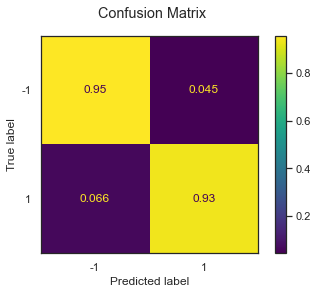

model quolity is (0.9157967988865693, 0.9444444444444444)


In [533]:
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
print(f'model quolity is {train_acc, test_acc}')

Text(0.5, 1.0, 'Lost function from time')

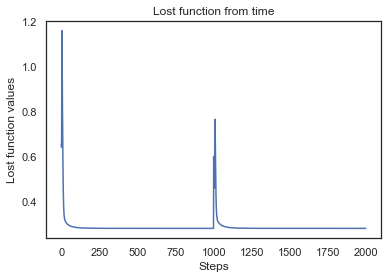

In [496]:
# Initialize plot
plot = plt.figure()

# Plot
ax = plot.add_subplot(1, 1, 1)
ax.plot(model_1.loss_values_array)

# Data
ax.set_xlabel('Steps')
ax.set_ylabel('Lost function values')
ax.set_title('Lost function from time')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


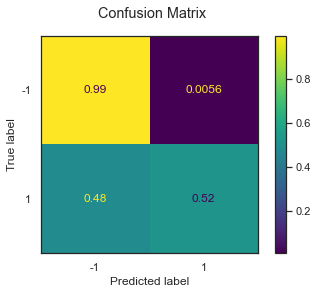

model quolity is (0.7724425887265136, 0.7527777777777778)


In [532]:
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)
print(f'model quolity is {train_acc, test_acc}')

Text(0.5, 1.0, 'Lost function from time')

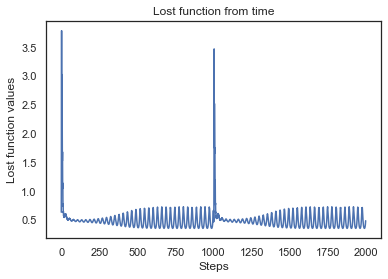

In [498]:
# Initialize plot
plot = plt.figure()

# Plot
ax = plot.add_subplot(1, 1, 1)
ax.plot(model_2.loss_values_array)

# Data
ax.set_xlabel('Steps')
ax.set_ylabel('Lost function values')
ax.set_title('Lost function from time')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


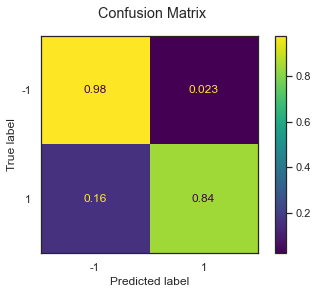

model quolity is (0.8921363952679193, 0.9083333333333333)


In [531]:
train_acc, test_acc = fit_evaluate(model_3, X_train, y_train, X_test, y_test)
print(f'model quolity is {train_acc, test_acc}')

Text(0.5, 1.0, 'Lost function from time')

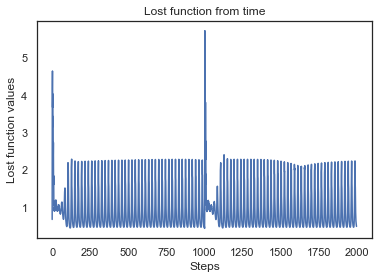

In [506]:
# Initialize plot
plot = plt.figure()

# Plot
ax = plot.add_subplot(1, 1, 1)
ax.plot(model_3.loss_values_array)

# Data
ax.set_xlabel('Steps')
ax.set_ylabel('Lost function values')
ax.set_title('Lost function from time')

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [507]:
## your code
#model = CustomLogisticRegression()
# C def = 1.0

In [517]:
model_C_1 = CustomLogisticRegression(C=0.45)
model_C_1.fit(X_train, y_train)

In [518]:
model_C_2 = CustomLogisticRegression(C=1.55)
model_C_2.fit(X_train, y_train)

In [519]:
model_C_3 = CustomLogisticRegression(C=2.15)
model_C_3.fit(X_train, y_train)

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


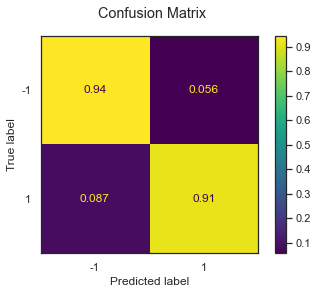

Model quolity  C=0.45 is (0.9039665970772442, 0.9277777777777778)


In [530]:
train_acc, test_acc = fit_evaluate(model_C_1, X_train, y_train, X_test, y_test)
print(f'Model quolity  C=0.45 is {train_acc, test_acc}')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


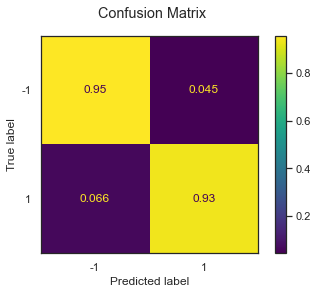

Model quolity when C=1.55 is (0.9137091162143354, 0.9444444444444444)


In [529]:
train_acc, test_acc = fit_evaluate(model_C_2, X_train, y_train, X_test, y_test)
print(f'Model quolity when C=1.55 is {train_acc, test_acc}')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


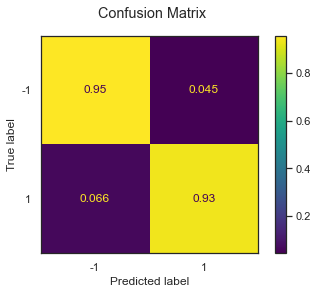

Model quolity when C=2.55 is (0.9137091162143354, 0.9444444444444444)


In [528]:
train_acc, test_acc = fit_evaluate(model_C_3, X_train, y_train, X_test, y_test)
print(f'Model quolity when C=2.55 is {train_acc, test_acc}')

Text(0.5, 1.0, 'Lost function from time')

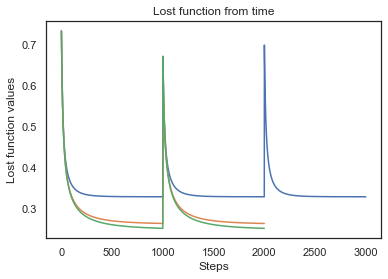

In [525]:
# Initialize plot
plot = plt.figure()

# Plot
ax = plot.add_subplot(1, 1, 1)
ax.plot(model_C_1.loss_values_array)
ax.plot(model_C_2.loss_values_array)
ax.plot(model_C_3.loss_values_array)

# Data
ax.set_xlabel('Steps')
ax.set_ylabel('Lost function values')
ax.set_title('Lost function from time')

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

In [ ]:
## your code

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


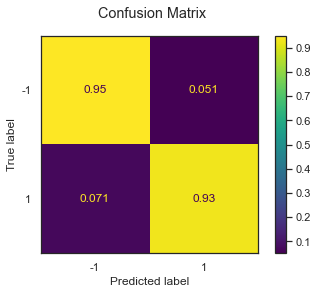

Качество модели при рандомной инициализации (0.9116214335421016, 0.9388888888888889)


In [527]:
model_Z_1  = CustomLogisticRegression(zero_init=True)

train_acc, test_acc = fit_evaluate(model_Z_1, X_train, y_train, X_test, y_test)
print(f'Качество модели при рандомной инициализации {train_acc, test_acc}')

p:\python projects\ai_curces\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


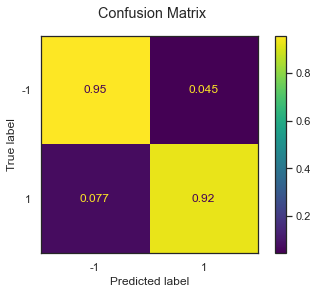

Качество модели при рандомной инициализации (0.9109255393180237, 0.9388888888888889)


In [534]:
model_Z_2  = CustomLogisticRegression(zero_init=False)

train_acc, test_acc = fit_evaluate(model_Z_2, X_train, y_train, X_test, y_test)
print(f'Качество модели при рандомной инициализации {train_acc, test_acc}')

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [ ]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [ ]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [38]:
PATH = "P:\\Python Projects\\AI_curces\\5_classification_linear_knn\\data\\"

In [39]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [294]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
8,0,1,"Wardlaw, Michael",male,27.0,2,1,474849,73.02,A7253,S
9,0,2,"Greigo, Rudy",male,66.0,0,0,6981,9.14,D2969,C
11,0,1,"Telschow, Robert",male,60.0,0,0,19600,31.50,A9055,S
12,0,3,"Stewart, Pat",male,36.0,0,0,434108,9.34,C8674,S
14,1,1,"Seaton, Karen",female,44.0,0,1,12425,28.40,D6945,C


In [295]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [296]:
data.duplicated().value_counts()

False    30881
dtype: int64

In [297]:
print(data.shape)

(30881, 11)


In [298]:
data.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [299]:
data = data.dropna()

In [300]:
print(data.shape)

(30881, 11)


In [313]:
count = data.shape[0]

In [314]:
print(count)

30881


In [315]:
data.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [316]:
assert data.isna().sum().sum() == 0

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [540]:
## your code
data.groupby('Sex').size()
N_females = (data['Sex'].tolist().count('female'))
N_males = (data['Sex'].tolist().count('male'))
N_females_alive = ((data['Survived'] == 1) & (data['Sex'] == 'female')).count()
N_males_alive = ((data['Survived'] == 1) & (data['Sex'] == 'male')).count()

In [541]:
print(f'On the sheep was {N_females} females')
print(f'On the sheep was {N_males} males')

print(f'Survived on the ship {N_females_alive} females')
print(f'Survived on the ship {N_males_alive} males')

On the sheep was 17449 females
On the sheep was 13432 males
Survived on the ship 30881 females
Survived on the ship 30881 males


In [545]:
print('Difference between female who was and male who was alive is.....')
a = N_females/N_females_alive
b = N_males/N_males_alive
print(f'N_females/N_females_alive {a}')
print(f'N_males/N_males_alive {b}')

Difference between female who was and male who was alive is.....
N_females/N_females_alive 0.565039992228231
N_males/N_males_alive 0.4349600077717691


<AxesSubplot:xlabel='Sex', ylabel='count'>

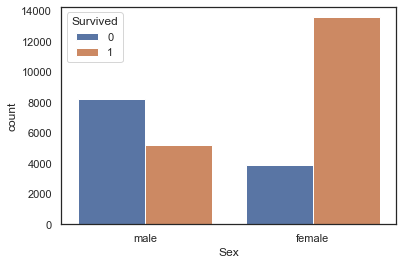

In [539]:
sns.countplot(x='Sex', hue='Survived', data = data)

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='count'>

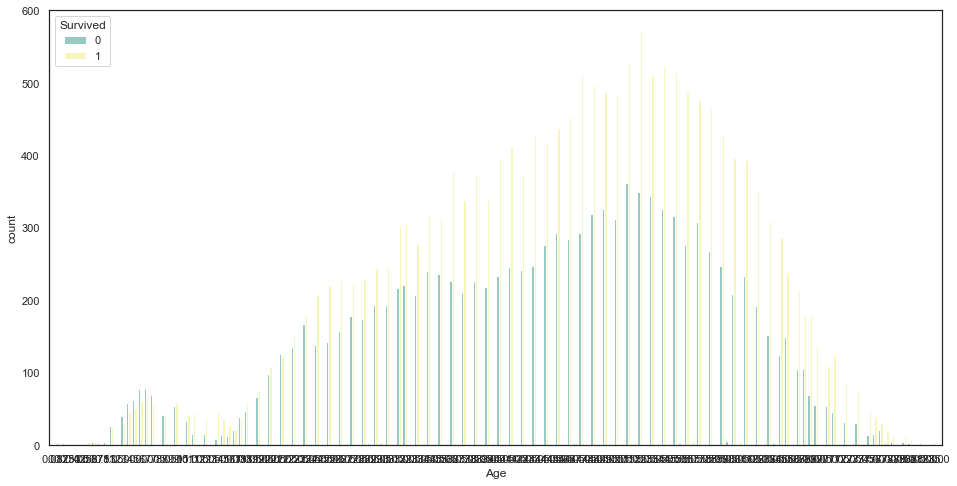

In [561]:
## your code
plt.figure(figsize=(16, 8))
sns.countplot(x='Age',
              hue='Survived',
              data=data,
              palette="Set3")

In [548]:
data.Age.describe()

count    30881.000000
mean        44.584046
std         15.212105
min          0.080000
25%         35.000000
50%         47.000000
75%         56.000000
max         85.000000
Name: Age, dtype: float64

In [553]:
print(f'Медианный возраст {data.groupby("Survived").median()["Age"]}')

print(f'Средний возраст {data.groupby("Survived").mean()["Age"]}')

Медианный возраст Survived
0    45.0
1    47.0
Name: Age, dtype: float64
Средний возраст Survived
0    43.138848
1    45.514256
Name: Age, dtype: float64


< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

< your thoughts >

In [592]:
data_cl1 = data[((data['Survived'] == 1) & (data['Pclass'] == 1))].shape[0]
data_cl2 = data[((data['Survived'] == 1) & (data['Pclass'] == 2))].shape[0]
data_cl3 = data[((data['Survived'] == 1) & (data['Pclass'] == 3))].shape[0]

In [593]:
data_em1 = data[((data['Survived'] == 1) & (data['Embarked'] == "S"))].shape[0]
data_em2 = data[((data['Survived'] == 1) & (data['Pclass'] == "C"))].shape[0]
data_em2 = data[((data['Survived'] == 1) & (data['Pclass'] == 'Q'))].shape[0]

In [594]:
data_cl1_em1 = data[((data['Survived'] == 1) & (data['Pclass'] == 1) & (data['Embarked'] == "S"))].shape[0]
data_cl1_em2 = data[((data['Survived'] == 1) & (data['Pclass'] == 1) & (data['Embarked'] == "C"))].shape[0]
data_cl1_em3 = data[((data['Survived'] == 1) & (data['Pclass'] == 1) & (data['Embarked'] == "Q"))].shape[0]

In [595]:
data_cl2_em1 = data[((data['Survived'] == 1) & (data['Pclass'] == 2) & (data['Embarked'] == "S"))].shape[0]
data_cl2_em2 = data[((data['Survived'] == 1) & (data['Pclass'] == 2) & (data['Embarked'] == "C"))].shape[0]
data_cl2_em3 = data[((data['Survived'] == 1) & (data['Pclass'] == 2) & (data['Embarked'] == "Q"))].shape[0]

In [598]:
data_cl3_em1 = data[((data['Survived'] == 1) & (data['Pclass'] == 3) & (data['Embarked'] == "S"))].shape[0]
data_cl3_em2 = data[((data['Survived'] == 1) & (data['Pclass'] == 3) & (data['Embarked'] == "C"))].shape[0]
data_cl3_em3 = data[((data['Survived'] == 1) & (data['Pclass'] == 3) & (data['Embarked'] == "Q"))].shape[0]

In [599]:
print(f'Survived from 1 class = {data_cl1}')
print(f'Survived from 2 class = {data_cl2}')
print(f'Survived from 3 class = {data_cl3}')

print(f'Survived from 1 class and embarced from "S" = {data_cl1_em1}')
print(f'Survived from 1 class and embarced from "C" = {data_cl1_em2}')
print(f'Survived from 1 class and embarced from "Q" = {data_cl1_em3}')

print(f'Survived from 2 class and embarced from "S" = {data_cl2_em1}')
print(f'Survived from 2 class and embarced from "C" = {data_cl2_em2}')
print(f'Survived from 2 class and embarced from "Q" = {data_cl2_em3}')

print(f'Survived from 2 class and embarced from "S" = {data_cl3_em1}')
print(f'Survived from 2 class and embarced from "C" = {data_cl3_em2}')
print(f'Survived from 2 class and embarced from "Q" = {data_cl3_em3}')

Survived from 1 class = 15677
Survived from 2 class = 2321
Survived from 3 class = 790
Survived from 1 class and embarced from "S" = 5123
Survived from 1 class and embarced from "C" = 8340
Survived from 1 class and embarced from "Q" = 2214
Survived from 2 class and embarced from "S" = 989
Survived from 2 class and embarced from "C" = 1157
Survived from 2 class and embarced from "Q" = 175
Survived from 2 class and embarced from "S" = 407
Survived from 2 class and embarced from "C" = 322
Survived from 2 class and embarced from "Q" = 61


Text(0.5, 1.0, 'Whow depend embarked with survived and no survived')

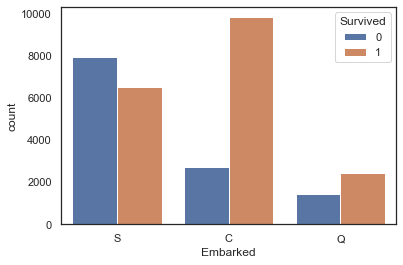

In [601]:
sns.countplot(x='Embarked', hue='Survived',  data=data)
ax.set_title('Whow depend embarked with survived and no survived')

Text(0.5, 1.0, 'Whow depend Pclass with survived and no survived')

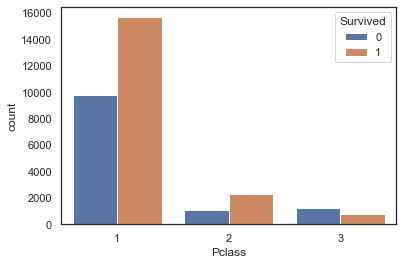

In [602]:
sns.countplot(x='Pclass', hue='Survived', data=data)
ax.set_title('Whow depend Pclass with survived and no survived')

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

In [607]:
for column in data.columns:
    missing_percentage = np.mean(data[column].isnull())
    print('{} - {}%'.format(column, round(missing_percentage * 100)))

Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 0%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 0%
Embarked - 0%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code

In [612]:
df = data.copy()

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30881 entries, 8 to 99995
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  30881 non-null  int64  
 1   Pclass    30881 non-null  int64  
 2   Name      30881 non-null  object 
 3   Sex       30881 non-null  object 
 4   Age       30881 non-null  float64
 5   SibSp     30881 non-null  int64  
 6   Parch     30881 non-null  int64  
 7   Ticket    30881 non-null  object 
 8   Fare      30881 non-null  float64
 9   Cabin     30881 non-null  object 
 10  Embarked  30881 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 3.8+ MB


In [635]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [636]:
L_E_C = LabelEncoder()

In [637]:
df['Sex'] = L_E_C.fit_transform(df['Sex'])

In [638]:
L_REG_1 = LogisticRegression(max_iter=1000,random_state=42)

In [639]:
L_REG_1 = cross_validate(L_REG_1,
                         df[['Pclass',
                             'Sex',
                             'Age',
                             'SibSp',
                             'Parch',
                             'Fare']],
                             df['Survived'],
                         scoring='accuracy',
                         cv=5,
                         return_train_score=True)

In [640]:
L_REG_1

{'fit_time': array([0.12342477, 0.12202787, 0.09702134, 0.1260283 , 0.12902951]),
 'score_time': array([0.00100231, 0.00200033, 0.00200057, 0.00100017, 0.00099969]),
 'test_score': array([0.71005342, 0.71632124, 0.71016839, 0.70984456, 0.70854922]),
 'train_score': array([0.71158517, 0.70953248, 0.71111111, 0.71111111, 0.71175875])}

In [641]:
KNN_1 = KNeighborsClassifier()

In [642]:
KNN_1 = cross_validate(KNN_1,
                       df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']],
                             df['Survived'],
                       scoring='accuracy',
                       cv=5,
                       return_train_score=True)

In [643]:
KNN_1

{'fit_time': array([0.04400992, 0.04100919, 0.04100895, 0.04200888, 0.04100847]),
 'score_time': array([0.12771749, 0.13102961, 0.12902999, 0.13003016, 0.13002968]),
 'test_score': array([0.66213372, 0.6609456 , 0.65204016, 0.65236399, 0.65544041]),
 'train_score': array([0.76594883, 0.76648452, 0.77105849, 0.76818458, 0.76709168])}

In [650]:
print(f'Logictic regression model score = {L_REG_1["test_score"]}')
print(f'KNN model score = {KNN_1["test_score"]}')

Logictic regression model score = [0.71005342 0.71632124 0.71016839 0.70984456 0.70854922]
KNN model score = [0.66213372 0.6609456  0.65204016 0.65236399 0.65544041]


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.